In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 6.3 MB/s 
     |████████████████████████████████| 453 kB 58.2 MB/s 


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-28 11:01:41--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from konlpy.tag import Okt
import os
from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
import re

plt.rc('font', family='Malgun Gothic')
train_df = pd.read_excel('/content/drive/MyDrive/sentiment_analysis.xlsx')
train_df.head()

,번호,value,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3
0,24070,1,청년,여성,"진로, 취업, 직장",해당없음,기쁨,신이 난,지금 난 기분이 너무 좋아.,굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?,오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.,그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?,그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.,집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.
1,27879,1,청년,여성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,나도 조카가 생겨! 너무 기뻐.,정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?,응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.,언니에게 꽃을 선물하려고 하시는군요.,NaN,NaN
2,51471,1,중년,여성,"직장, 업무 스트레스",해당없음,불안,불안,거래처와의 다음 계약이 무산될까봐 불안해.,많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?,딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.,계약을 성공적으로 마무리하실 수 있기를 기원해요.,NaN,NaN
3,7140,1,노년,남성,대인관계,만성질환 유,슬픔,염세적인,당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...,몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.,젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.,지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?,아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...,아내와의 대화로 기분이 나아졌으면 좋겠어요.
4,39663,1,노년,남성,재정,만성질환 유,슬픔,마비된,노년에 재정적으로 이루어 놓은게 없어서 걱정이야.,나이들어 재정적으로 어려워서 걱정되시는군요.,정말이지 막막해.,막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.,NaN,NaN


In [ ]:
train_df.fillna('', inplace = True)
train_df.drop(['번호', 'value' ,'연령', '성별', '상황키워드', '신체질환', '감정_소분류'],axis=1,inplace = True)

In [ ]:
sentimential_list = {'행복' : 0, '기쁨': 0, '분노' : 1, '불안' : 1, '당황' : 2, '슬픔' : 2, '상처' : 2}
train_df['label'] = train_df['감정_대분류'].map(sentimential_list)
train_df.head()

,감정_대분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,label
0,기쁨,지금 난 기분이 너무 좋아.,굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?,오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.,그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?,그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.,집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.,0
1,기쁨,나도 조카가 생겨! 너무 기뻐.,정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?,응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.,언니에게 꽃을 선물하려고 하시는군요.,,,0
2,불안,거래처와의 다음 계약이 무산될까봐 불안해.,많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?,딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.,계약을 성공적으로 마무리하실 수 있기를 기원해요.,,,1
3,슬픔,당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...,몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.,젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.,지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?,아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...,아내와의 대화로 기분이 나아졌으면 좋겠어요.,2
4,슬픔,노년에 재정적으로 이루어 놓은게 없어서 걱정이야.,나이들어 재정적으로 어려워서 걱정되시는군요.,정말이지 막막해.,막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.,,,2


텍스트 전처리 : text를 모든 문장을 합쳐서 처리



In [ ]:
train_df['text'] = train_df['사람문장1'] + ' ' + train_df['시스템응답1']  + ' ' + train_df['사람문장2'].map(str) + ' ' + train_df['시스템응답2']  + ' ' +train_df['사람문장3']  + ' ' + train_df['시스템응답3']
train_df['text'] = train_df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
train_df.drop_duplicates(subset = ['text'], inplace = True) #중복 제거

In [ ]:
print(sum(map(len, train_df['text'])) / len(train_df['text'])) # 평균 글자 수

156.32599047849592


In [ ]:
import random
import pickle
import re

wordnet = {}
with open("/content/drive/MyDrive/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)

In [ ]:
# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',str(line))

	return parseText

In [ ]:
########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words):
  new_words = words.copy()
  random_word_list = list(set([word for word in words]))
  random.shuffle(random_word_list)
  num_replaced = 0
  sentence = ""
  for random_word in random_word_list:
    synonyms = get_synonyms(random_word)
    if len(synonyms) >= 1:
      synonym = list(synonyms)
      new_words = [synonym[random.randrange(len(synonyms))] if word == random_word else word for word in new_words]
      sentence += ' '.join(new_words) + "\n"
      num_replaced += 1


  return sentence

In [ ]:
def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			synomyms.append(syn)
	except:
		pass

	return synomyms 

In [ ]:
def EDA(sentence, alpha_sr = 0.1, num_aug = 4):
  okt = Okt()
  sentence = get_only_hangul(sentence)
  morphs = okt.morphs(sentence)
  num_of_morphs = len(morphs)

  augmented_sentences = []
  num_new_per_technique = num_aug

  for i in range(num_new_per_technique):
    a_words = synonym_replacement(morphs)
    augmented_sentences = a_words.split('\n')

    augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
    '''
    if num_aug >= 1:
      augmented_sentences = augmented_sentences[:num_aug]
    else:
      keep_prob = num_aug / len(augmented_sentences)
      augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]'''

    augmented_sentences.append(sentence)
    return [sentence for sentence in list(set(augmented_sentences)) if sentence is not ""]

In [ ]:
new_data = pd.DataFrame(columns = ['감정_대분류', 'text', 'label'])
new_data

,감정_대분류,text,label


In [ ]:
import time
for i, data_value in tqdm(enumerate(train_df['text']), desc = "tqdm example", mininterval = 0.01):
    increase_text = EDA(data_value)
    for value in increase_text:
        new_data = new_data.append({'감정_대분류' : train_df.iloc[i, 0], 'text' : train_df.iloc[i, 8], 'label' : train_df.iloc[i, 7]}, ignore_index = True)


tqdm example: 74358it [1:15:23, 16.44it/s]


In [ ]:
new_data.to_csv('/content/drive/MyDrive/textaugment_sentiment.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/textaugment_sentiment.csv')


LSTM 딥러닝을 이용해서 예측하는 경우 -> 감정대분류를 label로 만든다.

In [ ]:
x_data = train_df['text']
y_data = train_df['감정_대분류']

X_train_data, X_test_data, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, stratify = y_data, random_state = 42)
X_train_data.shape, X_test_data.shape, y_train.shape, y_test.shape

((55768,), (18590,), (55768,), (18590,))

In [ ]:
#불용어 처리
import pickle
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '것','적', '내', '때']

X_train = []
X_test = []
if not os.path.isfile('/content/drive/MyDrive/train.pkl'):
  for sentence in tqdm(X_train_data):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/train.pkl","wb") as f:
    pickle.dump(X_train, f)
  for sentence in tqdm(X_test_data):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/test.pkl","wb") as f:
      pickle.dump(X_test, f)
else:
    with open("/content/drive/MyDrive/train.pkl","rb") as f:
        X_train = pickle.load(f)
    with open("/content/drive/MyDrive/test.pkl", "rb") as f:
        X_test = pickle.load(f)  

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 30
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17297
등장 빈도가 29번 이하인 희귀 단어의 수: 13540
단어 집합에서 희귀 단어의 비율: 78.27947042839799
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.9549672911589573


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
vocab_size

3758

In [ ]:
#텍스트 -> 다시 시퀀스화
total_cnt = vocab_size
tokenizer = Tokenizer(total_cnt)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 151
리뷰의 평균 길이 : 43.60776789556735


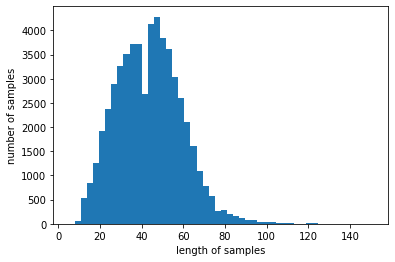

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 95.73231960981208


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
#y_train = to_categorical(y_train)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_test)
y_test = encoder.transform(y_test)
#y_test = to_categorical(y_test)

In [ ]:
encoder.classes_

array(['기쁨', '당황', '분노', '불안', '상처', '슬픔'], dtype=object)

In [ ]:
y_train, y_test

(array([5, 0, 5, ..., 4, 0, 4]), array([5, 5, 2, ..., 4, 5, 2]))

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55768, 70), (18590, 70), (55768,), (18590,))

In [ ]:
total_cnt

3758

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 70
hidden_units = 64
num_classes = 6

model = Sequential()
model.add(Embedding(total_cnt, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))
chkpoint_filepath = "/content/drive/MyDrive/sentiment_analysis.h5"

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 3)
mc = ModelCheckpoint(filepath = chkpoint_filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, validation_split=0.25, verbose = 1)

Epoch 1/5
654/654 [==============================] - ETA: 0s - loss: 1.3095 - accuracy: 0.4718
Epoch 1: val_accuracy improved from -inf to 0.64984, saving model to /content/drive/MyDrive/sentiment_analysis.h5
654/654 [==============================] - 54s 79ms/step - loss: 1.3095 - accuracy: 0.4718 - val_loss: 1.0322 - val_accuracy: 0.6498
Epoch 2/5
654/654 [==============================] - ETA: 0s - loss: 0.9092 - accuracy: 0.6926
Epoch 2: val_accuracy improved from 0.64984 to 0.68656, saving model to /content/drive/MyDrive/sentiment_analysis.h5
654/654 [==============================] - 48s 74ms/step - loss: 0.9092 - accuracy: 0.6926 - val_loss: 0.9252 - val_accuracy: 0.6866
Epoch 3/5
654/654 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.7254
Epoch 3: val_accuracy did not improve from 0.68656
654/654 [==============================] - 48s 73ms/step - loss: 0.8137 - accuracy: 0.7254 - val_loss: 0.9345 - val_accuracy: 0.6838
Epoch 4/5
654/654 [===============

In [ ]:
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [ ]:
import os
from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer

def transform_data(x_train, x_test):
  if not os.path.isfile('/content/drive/MyDrive/okt_train.npz'):
    tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
    tfidf.fit(x_train)
    x_train_okt = tfidf.transform(x_train)
    x_test_okt = tfidf.transform(x_test)
    save_npz('/content/drive/MyDrive/okt_train.npz', x_train_okt)
    save_npz('/content/drive/MyDrive/okt_test.npz', x_test_okt)
  else:
    x_train_okt = load_npz('/content/drive/MyDrive/okt_train.npz')
    x_test_okt = load_npz('/content/drive/MyDrive/okt_test.npz')

    return x_train_okt, x_test_okt

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
import time

def light_gbm_train(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
  lgbm_clf.fit(x_train_okt, y_train)
  preds = lgbm_clf.predict(x_test_okt)
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')
  print('LGBM Classifier accuracy score : ', accuracy_score(y_test, preds))
  print("LGBM Classifier\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('LGBM Classifier 분류 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

def LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  clf = LogisticRegression(max_iter = 1000, random_state = 0)
  clf.fit(x_train_okt, y_train)
  preds = clf.predict(x_test_okt)
  print('LogisticRegression accuracy score : ', accuracy_score(y_test, preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic Regression general set\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1)) 
  print('Logistic Regression 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time

def LogisticRegression_liblinear(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
  clf.fit(x_train_okt, y_train)
  preds = clf.predict(x_test_okt)
  print('LogisticRegression_liblinear accuracy score : ', accuracy_score(y_test,  preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic Regression liblinear")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('Logistic Regression liblinear 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import time

def Logistic_with_CountVectorizer(x_data, y_data):
  start = time.time()
  count_vec = CountVectorizer(tokenizer = okt.morphs)
  x_train_data = count_vec.fit_transform(x_data)
  x_train, x_test, y_train, y_test = train_test_split(x_train_data, y_data, test_size = 0.25, random_state = 156)
  clf = LogisticRegression(max_iter = 1000, solver = 'liblinear',)
  clf.fit(x_train, y_train)
  preds = clf.predict(x_test)
  print('Logistic with CountVectorizer accuracy score : ', accuracy_score(y_test, preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic with CountVectorizer\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('Logistic with CountVectorizer 걸린 시간 : ', time.time() - start)

In [ ]:
from konlpy.tag import Okt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from scipy.sparse import save_npz, load_npz


'''train_df['text'] = train_df['사람문장1'] + train_df['시스템응답1'] + train_df['사람문장2'].map(str) + train_df['시스템응답2'] + train_df['사람문장3'] + train_df['시스템응답3']
x_data =  train_df['text'].apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', " ", x)).values
y_data = train_df['label']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify = y_data, test_size = 0.25, random_state = 42)

okt = Okt()

if not os.path.isfile('second_train.npz'):
  tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
  tfidf.fit(x_train)
  x_train_okt = tfidf.transform(x_train)
  x_test_okt = tfidf.transform(x_test)
  save_npz('second_train.npz', x_train_okt)
  save_npz('second_test.npz', x_test_okt)
else:
  x_train_okt = load_npz('second_train.npz')
  x_test_okt = load_npz('second_test.npz')'''

print('===================전체 정확도=================')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.fit_transform(y_train)

encoder = LabelEncoder()
encoder.fit(y_test)
y_test = encoder.fit_transform(y_test)

X_train, X_test = transform_data(X_train_data, X_test_data)
light_gbm_train(X_train, X_test, y_train, y_test)
LogisticRegression_train(X_train, X_test, y_train, y_test)
LogisticRegression_liblinear(X_train, X_test, y_train, y_test)
#Logistic_with_CountVectorizer(x_data, y_data)

===================전체 정확도=================


TypeError: ignored

In [ ]:
X_train

[['돈',
  '없다',
  '낙담하다',
  '있다',
  '무슨',
  '일이',
  '있다',
  '은행',
  '에서',
  '대출',
  '을',
  '거절',
  '건강',
  '자다',
  '챙기다',
  '칠십',
  '대다',
  '만',
  '성',
  '질환',
  '없다',
  '건강하다',
  '바라다'],
 ['이제',
  '계획',
  '임신',
  '을',
  '해도',
  '되다',
  '결정',
  '을',
  '내리다',
  '이유',
  '무엇',
  '인가요',
  '원하다',
  '만큼',
  '돈',
  '모으다',
  '임신',
  '적합하다',
  '몸',
  '상태',
  '만들다',
  '계획',
  '을',
  '순',
  '조',
  '롭',
  '게',
  '이행',
  '자신감',
  '을',
  '가지',
  '고',
  '계시다',
  '좋다',
  '부모',
  '되다',
  '위',
  '조건',
  '을',
  '스스로',
  '갖추다',
  '두다',
  '생각',
  '계획',
  '처럼',
  '순',
  '조',
  '롭',
  '게',
  '가족',
  '을',
  '만들다',
  '나가다',
  '바라다'],
 ['분명',
  '동생',
  '먼저',
  '잘못',
  '같다',
  '엄마',
  '나',
  '만',
  '혼내다',
  '기분',
  '을',
  '헤아리다',
  '주지',
  '못',
  '비통하다',
  '그러니까',
  '엄마',
  '대화',
  '자다',
  '이루어지다',
  '않다',
  '같다',
  '엄마',
  '와의',
  '관계',
  '어떻다',
  '해결',
  '가요',
  '솔직하다',
  '마음',
  '을',
  '표현',
  '자다',
  '되다',
  '응원'],
 ['친구',
  '약속',
  '장소',
  '잘못',
  '알다',
  '바람',
  '엉뚱하다',
  '곳',
  '혼자',
  '있다',
  '고립',
  '되다'

In [ ]:
text = ["나 진짜 너 오늘 죽여버림 ㅋ", "그 영화 진짜 너무 재밌었던 것 같아서 행복해",
        "요즘 인생 현타 겁나 옴 ㅋ", "나 오늘 시험 100점 맞을 겨", "짜증나", "나는 뭘 해도 안될거야", "너 때문에 내가 지금 너무 빡친다"]
clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
clf.fit(x_train_okt, y_train)
score = clf.predict(tfidf.transform(text))
print(score)
print(clf.predict_proba(tfidf.transform(text)))

In [ ]:
test_df = pd.read_excel('/content/test_data.xlsx')
test_df.head()

In [ ]:
test_df.info()

In [ ]:
test_df.fillna('', inplace = True)

In [ ]:
sentimential_list = {'행복' : 0, '기쁨': 0, '분노' : 1, '불안' : 1, '당황' : 2, '슬픔' : 2, '상처' : 2}
test_df['label'] = test_df['감정_대분류'].map(sentimential_list)

NameError: ignored

In [ ]:
test_df['text'] = test_df['사람문장1'] + test_df['시스템응답1'] + test_df['사람문장2'].map(str) + test_df['시스템응답2'] + test_df['사람문장3'] + test_df['시스템응답3']
test_df.head()

NameError: ignored

In [ ]:
start = time.time()
clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
clf.fit(x_train_okt, y_train)
score = clf.predict(tfidf.transform(test_df['text']))
test_df['prediction'] = score
test_df['result'] = test_df['label'] - test_df['prediction']
print('전체 정확도는 : ', end = ' ')
print(len(test_df[test_df['result'] == 0]) / len(test_df['result']))
print('걸린 시간 : ', time.time() - start)
print("========================")

In [ ]:
start = time.time()
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
score = lgbm_clf.predict(tfidf.transform(test_df['text']))
test_df['LGB_prediction'] = score
test_df['LGB_result'] = test_df['label'] - test_df['LGB_prediction']
print('LGBM 전체 정확도는 : ', end = ' ')
print(len(test_df[test_df['LGB_result'] == 0]) / len(test_df['result']))
print('걸린 시간 : ', time.time() - start)

In [ ]:
print(len(test_df[test_df['result'] == 0]) / len(test_df['result']))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df = 5).fit(x_data)

In [ ]:
import re
#train_df['text'] = train_df['사람문장1'] + train_df['시스템응답1'] + train_df['사람문장2'].map(str) + train_df['시스템응답2'] + train_df['사람문장3'] + train_df['시스템응답3']
x_data = train_df['text']
y_data = train_df['label']

x_data = x_data.apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', " ", x)).values
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify = y_data, test_size = 0.25, random_state = 42)

from konlpy.tag import Okt

okt = Okt()
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
tfidf.fit(x_train)
x_train_okt = tfidf.transform(x_train)
x_test_okt = tfidf.transform(x_test)
print('=======text를 다 합치면=======')
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
preds = lgbm_clf.predict(x_test_okt)
confusion = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted')
recall = recall_score(y_test, preds, average = 'weighted')
f1 = f1_score(y_test, preds, average = 'weighted')

print("LGBM Classifier\n")
print(confusion)
print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'.format(accuracy,precision,recall,f1))#LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test)
#LogisticRegression_liblinear(x_train_okt, x_test_okt, y_train, y_test)
#Logistic_with_CountVectorizer(x_data, y_data)

=======text를 다 합치면=======
LGBM Classifier

[[ 2647    34   431]
 [   38  1794  1294]
 [  176   363 11937]]
정확도: 0.8752
정밀도: 0.8731
재현율: 0.8752
f1: 0.8690


In [ ]:
print('=======text를 다 합치면=======')
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
preds = lgbm_clf.predict(x_test_okt)
confusion = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted')
recall = recall_score(y_test, preds, average = 'weighted')
f1 = f1_score(y_test, preds, average = 'weighted')

print("LGBM Classifier\n")
print(confusion)
print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'.format(accuracy,precision,recall,f1))#LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test)

=======text를 다 합치면=======
LGBM Classifier

[[ 2647    34   431]
 [   38  1794  1294]
 [  176   363 11937]]
정확도: 0.8752
정밀도: 0.8731
재현율: 0.8752
f1: 0.8690


In [ ]:
text = ["나 진짜 너 오늘 죽여버림 ㅋ", "그 영화 진짜 너무 재밌었던 것 같아서 행복해",
        "요즘 인생 현타 겁나 옴 ㅋ", "나 오늘 시험 100점 맞을 겨"]
score = lgbm_clf.predict(tfidf.transform(text))
print(score)
print(lgbm_clf.predict_proba(tfidf.transform(text)))

In [ ]:
if not os.path.isfile('okt_train.npz'):
  tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
  tfidf.fit(x_train)
  x_train_okt = tfidf.transform(x_train)
  x_test_okt = tfidf.transform(x_test)
  save_npz('okt_train.npz', x_train_okt)
  save_npz('okt_test.npz', x_test_okt)
else:
  x_train_okt = load_npz('okt_train.npz')
  x_test_okt = load_npz('okt_test.npz')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(max_iter = 1000, random_state = 0)
params = {'C' : [0.01, 0.1, 0.5,  1, 5, 10]}
grid_cv = GridSearchCV(clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv.fit(x_train_okt, y_train)

print(grid_cv.best_params_, grid_cv.best_score_)

In [ ]:
count_vec.vocabulary_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.utils.fixes import loguniform

sgd = SGDClassifier(loss = 'log', random_state = 42)
param_dist = {'alpha' : loguniform(0.0001, 100.0)}

rsv_okt = RandomizedSearchCV(estimator = sgd, param_distributions = param_dist,
                             n_iter = 50, random_state = 42, verbose = 1)
rsv_okt.fit(x_train_okt, y_train)

In [ ]:
print(rsv_okt.best_score_)
print(rsv_okt.best_params_)